In [191]:
import numpy as np
import utils
import matplotlib.pyplot as plt
from tqdm import tqdm
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


The Burgers equation, represented by the partial differential equation (PDE):

\begin{equation}
    \frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = \nu \frac{\partial^2 u}{\partial x^2}
    \tag{PDE}
\end{equation}

is accompanied by an initial condition (IC):

\begin{equation}
    u(x,0)= f(x) \tag{IC}
\end{equation}

and periodic boundary condition (BC):

\begin{equation}
    \forall t\in \mathbb{R}_+ \quad u(0,t)= u(L,t)\tag{BC}
\end{equation}

Data from the burgers equation is simulated by using finite difference. This i done by by dividing the x domain $[0,L]$ into $n$ points with a stepsize $$\Delta x = n^{-1}L$$
for a sufficiently small $\Delta t$ 

\begin{equation}
    u_i^{n+1}=u_i^n-\frac{\Delta t}{\Delta x}\left(u_i^n\left(u_{i+1}^n-u_{i-1}^n\right)\right)+\nu \frac{\Delta t}{\Delta x^2}\left(u_{i+1}^n-2 u_i^n+u_{i-1}^n\right)
\end{equation}
where $u^n_i$ represents the value of $u$ at grid point $i$ at time step $n$


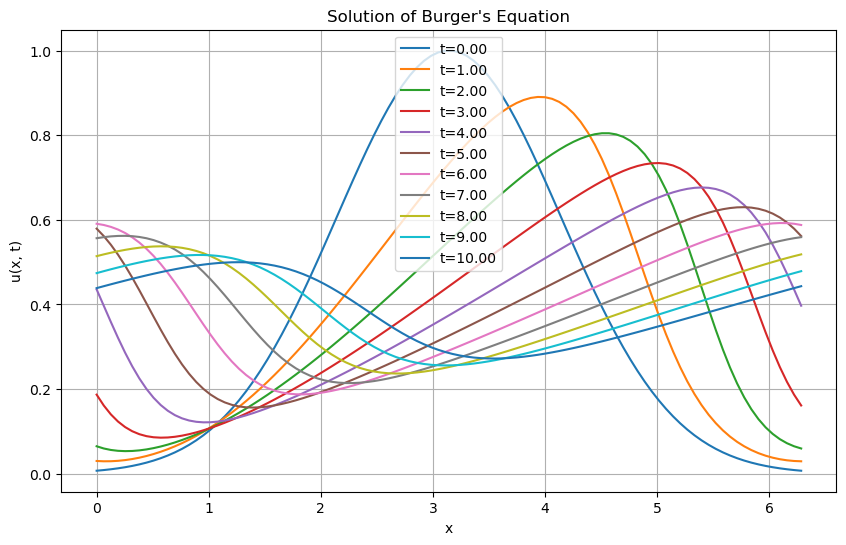

In [192]:

# Example usage
L = 2*np.pi
n = 100
x_grid = np.linspace(0, L, n) # spatial grid
dt = 0.001 # time step size
t_max = 10 # maximum simulation time
u_initial = utils.u_initial_3(L=L, n = n)
nu = 0.1 # diffusion coefficient

u_solution, t_points = utils.burgers_equation_simulation(u_initial, x_grid, dt, t_max, nu)

# Plotting
plt.figure(figsize=(10, 6))
for i in range(0, len(t_points), int(len(t_points)/10)):  # Plot every 10th solution
    plt.plot(x_grid, u_solution[:, i], label=f"t={t_points[i]:.2f}")

plt.title("Solution of Burger's Equation")
plt.xlabel("x")
plt.ylabel("u(x, t)")
plt.legend()
plt.grid(True)
plt.show()

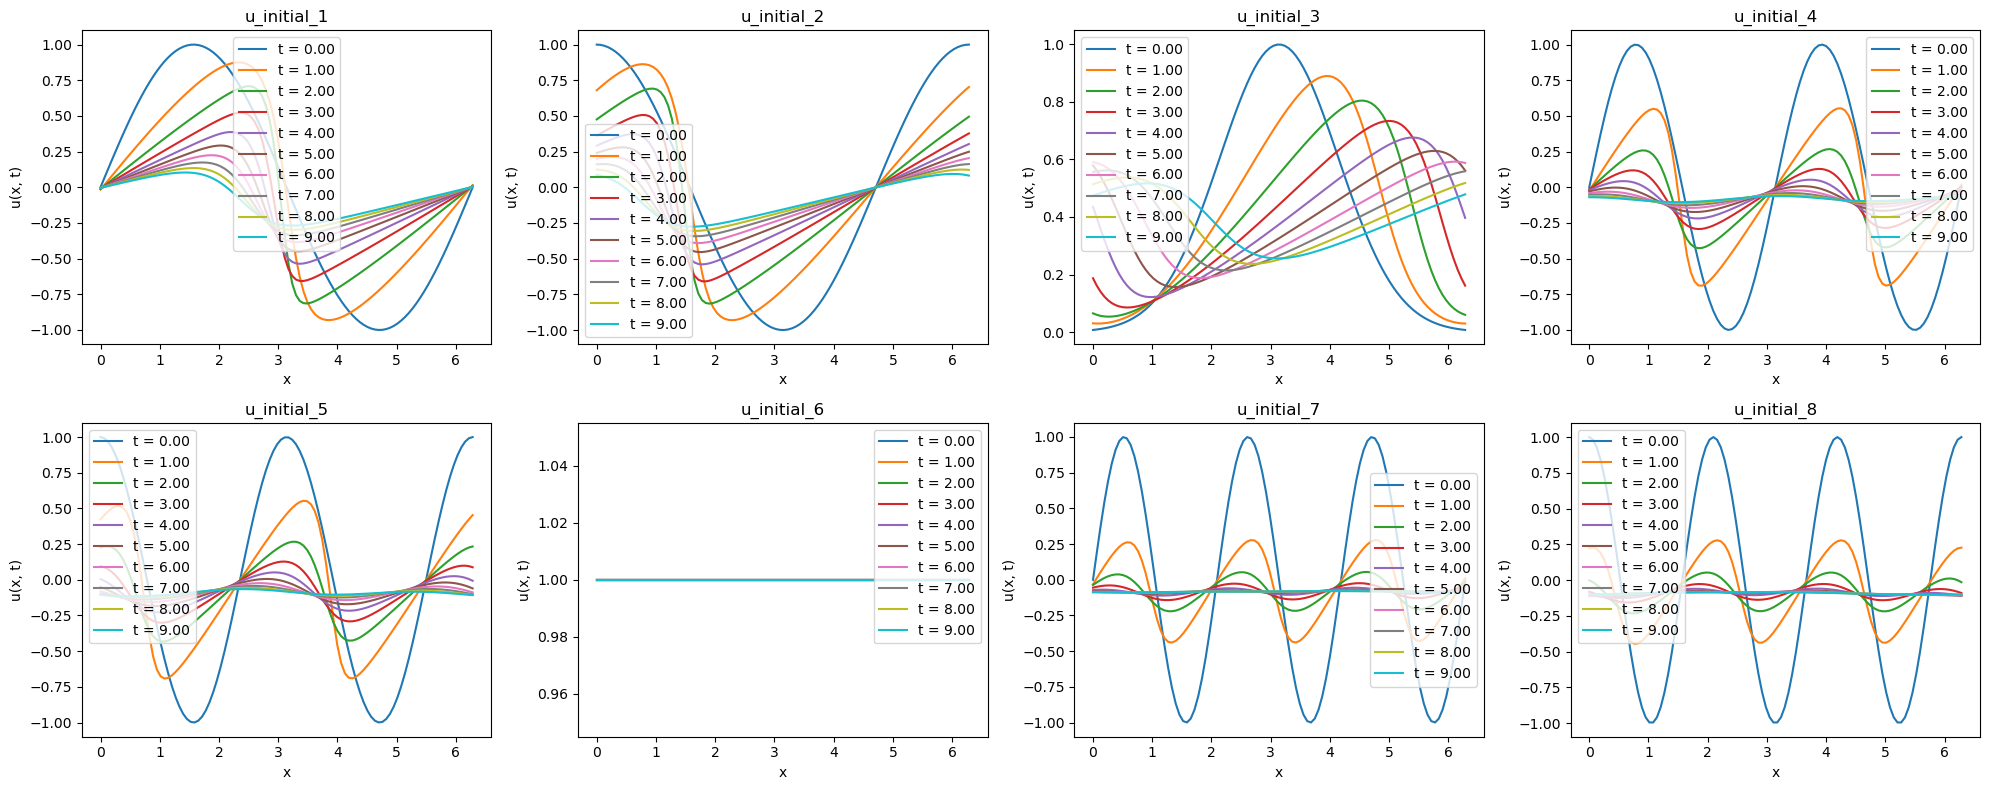

In [193]:
# Example usage
L = 2 * np.pi
n = 100
x_grid = np.linspace(0, L, n)  # Spatial grid
dt = 0.001  # Time step size
t_max = 10.0  # Maximum simulation time
nu = 0.1  # Diffusion coefficient

# Define a dictionary of initial condition functions
initial_conditions = {
    'u_initial_1': utils.u_initial_1,
    'u_initial_2': utils.u_initial_2,
    'u_initial_3': utils.u_initial_3,
    'u_initial_4': utils.u_initial_4,
    'u_initial_5': utils.u_initial_5,
    'u_initial_6': utils.u_initial_6,
    'u_initial_7': utils.u_initial_7,
    'u_initial_8': utils.u_initial_8,
}

# Plot the solutions for each initial condition in a 2x5 grid
fig, axs = plt.subplots(2, 4, figsize=(20, 8))
axs = axs.ravel()

for ax, (name, init_func) in zip(axs, initial_conditions.items()):
    u_initial = init_func(L, n)
    u_solution, t_points = utils.burgers_equation_simulation(u_initial, x_grid, dt, t_max, nu)
    
    # Plot every int(n/10) time points
    time_indices = np.arange(0, int(t_max/dt), int(t_max/dt/10))
    for idx in time_indices:
        ax.plot(x_grid, u_solution[:, idx], label=f't = {t_points[idx]:.2f}')
    
    ax.set_title(name)
    ax.set_xlabel('x')
    ax.set_ylabel('u(x, t)')
    ax.legend()

plt.tight_layout()
plt.show()


# Generate training data
training data is gernerated from random linear combinations of the above ICs, random $\nu$ and random $L$

In [194]:
L = 2*np.pi
t_max = 1 # Maximum simulation time
nu = 0.1 

# Simulation settings
n = 200
dt = 0.001 #0.001  # Time step size

# Downsample the simulation for training
space_res = 80
time_res = 50

n_simulations = 150  # Number of simulations
initial_conditions = {
    'u_initial_1': utils.u_initial_1,
    'u_initial_2': utils.u_initial_2,
    'u_initial_3': utils.u_initial_3,
    'u_initial_4': utils.u_initial_4,
    'u_initial_5': utils.u_initial_5,
    'u_initial_6': utils.u_initial_6,
    'u_initial_7': utils.u_initial_7,
    'u_initial_8': utils.u_initial_8,
}
x_grid,u_t_train, u_0_train = utils.simulate_IC(n_simulations,initial_conditions,L, n, t_max, dt, nu,
                                                plotting=False,keep_first_t=False,
                                                space_res=space_res,time_res=time_res)

Simulations: 100%|██████████| 150/150 [00:20<00:00,  7.18it/s]


In [159]:
import torch,sys
from neuralop.models import TFNO
from neuralop import Trainer
import neuralop.training.callbacks as callbacks
from neuralop.utils import count_model_params
from neuralop import LpLoss, H1Loss
from neuralop.datasets.tensor_dataset import TensorDataset
from neuralop.datasets.output_encoder import UnitGaussianNormalizer
from neuralop.datasets.transforms import PositionalEmbedding2D
from neuralop.datasets.data_transforms import DefaultDataProcessor

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Downsample the training data
X = torch.tensor(u_0_train, dtype=torch.float32).to(device)
y = torch.tensor(u_t_train, dtype=torch.float32).to(device)
X = X.unsqueeze(1)
y = y.unsqueeze(1)

train_db = TensorDataset(X,y)

train_loader = torch.utils.data.DataLoader(
    train_db,
    batch_size=1,
    shuffle=True,
    num_workers=0,
    pin_memory=True,
    persistent_workers=False,
)

reduce_dims = list(range(X.ndim))
#input_encoder = UnitGaussianNormalizer(dim=reduce_dims)
#input_encoder.fit(X)
pos_encoding = PositionalEmbedding2D(grid_boundaries=[[0,t_max],[0,L]])


# if encoding == "channel-wise":
#     reduce_dims = list(range(y_train.ndim))
# elif encoding == "pixel-wise":
#     reduce_dims = [0]

# output_encoder = UnitGaussianNormalizer(dim=reduce_dims)
# output_encoder.fit(y_train)

data_processor = DefaultDataProcessor(
    in_normalizer=None,
    out_normalizer=None,
    positional_encoding=pos_encoding
)


In [160]:
# Test data
# resolutions space_res x time_res
test_resolutions = [[space_res,time_res], [25,25],[50,50],[100,100]]
n_simulations = 5 # Number of simulations per resolution
test_loaders = {}
for res in test_resolutions:
    x_grid_test,u_t_test, u_0_test = utils.simulate_IC(n_simulations,initial_conditions,L, n, t_max, dt, nu,
                                                plotting=False,keep_first_t=False,
                                                space_res=res[0],time_res=res[1])
    X_test = torch.tensor(u_0_test, dtype=torch.float32).to(device)
    y_test = torch.tensor(u_t_test, dtype=torch.float32).to(device)
    X_test = X_test.unsqueeze(1)
    y_test = y_test.unsqueeze(1)

    test_db = TensorDataset(X_test,y_test)

    test_loader = torch.utils.data.DataLoader(
        test_db,
        batch_size=1,
        shuffle=True,
        num_workers=0,
        pin_memory=True,
        persistent_workers=False,
)
    test_loaders[f'{res[0]}x{res[1]}'] = test_loader

Simulations: 100%|██████████| 5/5 [00:01<00:00,  2.96it/s]


In [161]:
for idx, sample in enumerate(train_loader):
    print(sample['x'].shape, sample['y'].shape)
    sample = data_processor.preprocess(sample)
    print(sample['x'].shape, sample['y'].shape)
    selected_sample = sample
    break

torch.Size([1, 1, 50, 80]) torch.Size([1, 1, 50, 80])
torch.Size([1, 3, 50, 80]) torch.Size([1, 1, 50, 80])


In [162]:
model = TFNO(n_modes=(16,16)
             , hidden_channels=32, in_channels=3,projection_channels=64, factorization='tucker', rank=0.42)
model = model.to(device)

n_params = count_model_params(model)
print(f'\nOur model has {n_params} parameters.')
sys.stdout.flush()


Our model has 523257 parameters.


In [163]:
optimizer = torch.optim.Adam(model.parameters(), 
                                lr=8e-3, 
                                weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)

In [164]:
l2loss = LpLoss(d=2, p=2)
h1loss = H1Loss(d=2)

train_loss = h1loss
eval_losses={'l2': l2loss} # 'h1': h1loss

In [165]:
callback = callbacks.BasicLoggerCallback()
trainer = Trainer(model=model, n_epochs=20,
                  device=device,
                  data_processor=data_processor,
                  wandb_log=False,
                  log_test_interval=3,
                  use_distributed=False,
                  callbacks=[callback],
                  verbose=True)

using standard method to load data to device.
using standard method to compute loss.
self.override_load_to_device=False
self.overrides_loss=False


In [166]:
trainer.train(train_loader=train_loader,
              test_loaders=test_loaders, # Note: can be set to dict() if no test set is available
              optimizer=optimizer,
              scheduler=scheduler, 
              regularizer=False, 
              training_loss=train_loss,
              eval_losses=eval_losses)

Training on 150 samples
Testing on [5, 5, 5, 5] samples         on resolutions ['80x50', '25x25', '50x50', '100x100'].


Raw outputs of size out.shape=torch.Size([1, 1, 50, 80])
[0] time=4.84, avg_loss=5.3819, train_err=0.7176, 80x50_l2=0.5620, 25x25_l2=0.9180, 50x50_l2=0.5729, 100x100_l2=0.5121
[3] time=4.45, avg_loss=1.8783, train_err=0.2504, 80x50_l2=0.1072, 25x25_l2=0.6921, 50x50_l2=0.0835, 100x100_l2=0.0938
[6] time=4.48, avg_loss=1.2723, train_err=0.1696, 80x50_l2=0.0939, 25x25_l2=0.6787, 50x50_l2=0.1011, 100x100_l2=0.0937
[9] time=4.50, avg_loss=1.0459, train_err=0.1394, 80x50_l2=0.1356, 25x25_l2=0.6497, 50x50_l2=0.1209, 100x100_l2=0.1218
[12] time=4.40, avg_loss=1.0131, train_err=0.1351, 80x50_l2=0.0688, 25x25_l2=0.7128, 50x50_l2=0.0580, 100x100_l2=0.0591
[15] time=4.42, avg_loss=0.7727, train_err=0.1030, 80x50_l2=0.0659, 25x25_l2=0.7110, 50x50_l2=0.0617, 100x100_l2=0.0624
[18] time=4.41, avg_loss=0.5871, train_err=0.0783, 80x50_l2=0.0341, 25x25_l2=0.6976, 50x50_l2=0.0311, 100x100_l2=0.0355


{'100x100_l2': 0.035453208908438685}

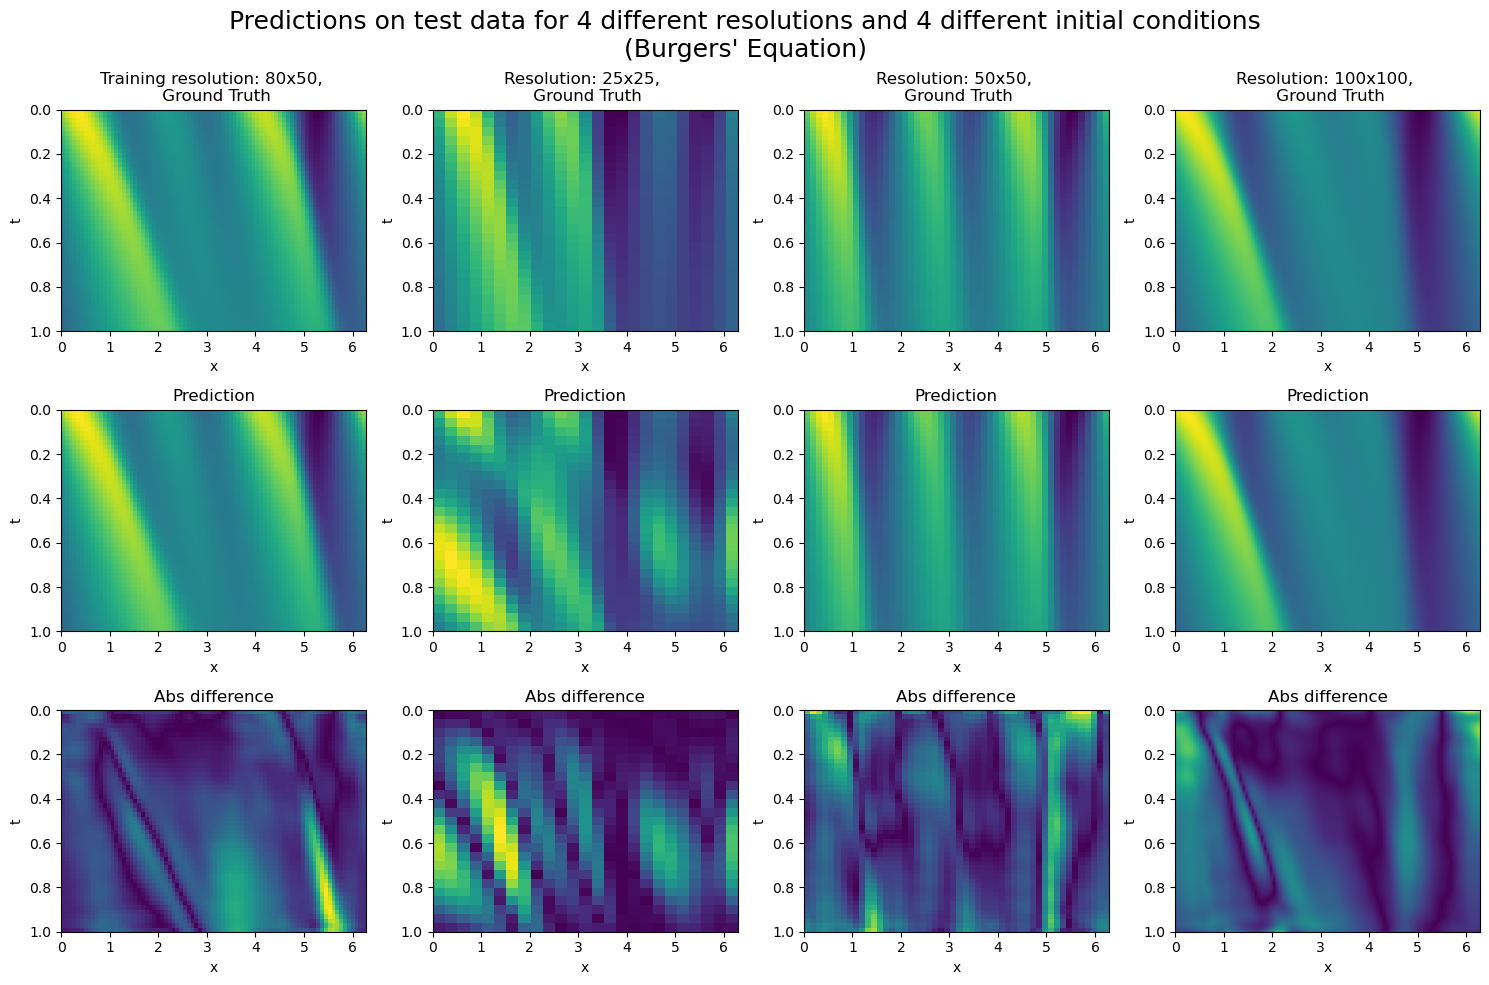

In [190]:
m = len(test_loaders)
fig, axs = plt.subplots(3, m, figsize=(15, 10))

for i, (resolution, loader) in enumerate(test_loaders.items()):
    sample = loader.dataset[0]
    space_res, time_res = resolution.split('x')
    space_res = int(space_res)
    time_res = int(time_res)
    x_grid = np.linspace(0, L, n)  # Spatial grid
    u_0 = sample['x'].detach().cpu().numpy()
    u_t = sample['y'].detach().cpu().numpy()
    #u_t_pred = model(data_processor(sample['x'])).detach().cpu().numpy()
    u_initial = u_0[0][0]

    # Plot the data in the corresponding subplot
    axs[0, i].imshow(u_t.squeeze(), aspect='auto',extent=[0,L,t_max,0])
    if i == 0:
        axs[0, i].set_title(f'Training resolution: {resolution}, \n Ground Truth')
    else:
        axs[0, i].set_title(f'Resolution: {resolution}, \n Ground Truth')
    axs[0, i].set_xlabel('x')
    axs[0, i].set_ylabel('t')
    data_processor.preprocess(sample, batched=False)['x']
    axs[1, i].imshow(model(sample['x'].unsqueeze(0)).squeeze().detach().cpu().numpy(), aspect='auto',extent=[0,L,t_max,0])
    axs[1, i].set_title(f'Prediction')
    axs[1, i].set_xlabel('x')
    axs[1, i].set_ylabel('t')
    
    axs[2, i].imshow(abs(u_t.squeeze()-model(sample['x'].unsqueeze(0)).squeeze().detach().cpu().numpy()), aspect='auto',extent=[0,L,t_max,0])
    axs[2, i].set_title(f'Abs difference')
    axs[2, i].set_xlabel('x')
    axs[2, i].set_ylabel('t')
fig.suptitle(f"Predictions on test data for {m} different resolutions and {m} different initial conditions\n(Burgers' Equation)", fontsize=18)

plt.tight_layout()
plt.show()
